In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import datetime
import torch
import os
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

col_list = ['Electric Current']
dataframe = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/sensor_data4.csv', usecols=col_list)

dataframe2 = np.array(dataframe).flatten()
dataframe2.shape

(732,)

In [ ]:
# 직접 한 것
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(dataframe2, axis=1))
all_data = scaler.transform(np.expand_dims(dataframe2, axis=1))
all_data.shape
seq_length = 10

def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X_all, y_all = create_sequences(all_data, seq_length)
X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

In [ ]:
def train_model(
  model,
  train_data,
  train_labels,
  test_data=None,
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')
  optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 60
  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)
  for t in range(num_epochs):
    model.reset_hidden_state()
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(), y_train)
    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()
      if t % 10 == 0:
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')
    train_hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
  return model.eval(), train_hist, test_hist

In [ ]:
class CoronaVirusPredictor(nn.Module):
  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()
    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers
    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )
    self.linear = nn.Linear(in_features=n_hidden, out_features=1)
  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )
  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [ ]:
model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=64,
  seq_len=seq_length,
  n_layers=2
)

model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 271.1722106933594
Epoch 10 train loss: 67.93873596191406
Epoch 20 train loss: 25.813879013061523
Epoch 30 train loss: 27.320758819580078
Epoch 40 train loss: 23.275583267211914
Epoch 50 train loss: 22.480180740356445


In [ ]:
TIME_TO_PREDICT = 50
with torch.no_grad():
  test_seq = X_all[:1]
  preds = []
  for _ in range(TIME_TO_PREDICT):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()
  
  predicted_cases = scaler.inverse_transform(np.expand_dims(preds, axis=0)).flatten()

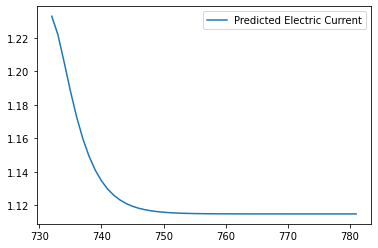

In [ ]:
my_index=range(dataframe2.size,dataframe2.size+TIME_TO_PREDICT)
predicted_cases = pd.Series(
  data=predicted_cases,
  index=my_index
)
plt.plot(predicted_cases, label='Predicted Electric Current')
plt.legend();

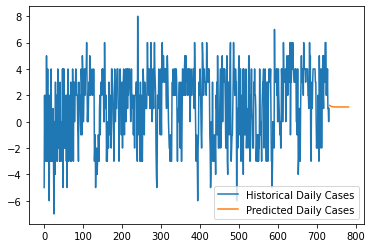

In [ ]:

plt.plot(dataframe, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();